In [1]:
import pandas                             as      pd
import numpy                              as      np
import matplotlib.pyplot                  as      plt
import seaborn                            as      sns
from   IPython.display                    import  display
from   pylab                              import  rcParams 
from   datetime                           import  datetime, timedelta
from statsmodels.tsa.stattools            import  adfuller
from statsmodels.tsa.stattools            import  pacf
from statsmodels.tsa.stattools            import  acf
from statsmodels.graphics.tsaplots        import  plot_pacf
from statsmodels.graphics.tsaplots        import  plot_acf
from statsmodels.graphics.gofplots        import  qqplot
from statsmodels.tsa.seasonal             import  seasonal_decompose
from statsmodels.tsa.arima_model          import  ARIMA,ARMA
from statsmodels.tsa.statespace.sarimax   import  SARIMAX
from arch import arch_model
from statsmodels.tsa.api import ExponentialSmoothing,SimpleExpSmoothing,Holt
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['figure.figsize'] = [15,8]

In [26]:
def MAE(y_true,y_pred):
    return np.mean((np.abs(y_true - y_pred)))

def MAPE(y_true,y_pred):
    return np.mean((np.abs(y_true - y_pred))/(y_true))*100

In [2]:
df = pd.read_csv('residential_power_usage_2016_to_2020.csv')
df.head()

,StartDate,Value (kWh),day_of_week,notes
0,2016-01-06 00:00:00,1.057,2,weekday
1,2016-01-06 01:00:00,1.171,2,weekday
2,2016-01-06 02:00:00,0.560,2,weekday
3,2016-01-06 03:00:00,0.828,2,weekday
4,2016-01-06 04:00:00,0.932,2,weekday


In [3]:
df.tail()

,StartDate,Value (kWh),day_of_week,notes
35947,2020-07-07 19:00:00,1.307,1,weekday
35948,2020-07-07 20:00:00,2.872,1,weekday
35949,2020-07-07 21:00:00,2.138,1,weekday
35950,2020-07-07 22:00:00,2.199,1,weekday
35951,2020-07-07 23:00:00,1.809,1,weekday


In [4]:
df.shape

(35952, 4)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35952 entries, 0 to 35951
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   StartDate    35952 non-null  object 
 1   Value (kWh)  35952 non-null  float64
 2   day_of_week  35952 non-null  int64  
 3   notes        35952 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 1.1+ MB


In [6]:
df.isnull().sum()

StartDate      0
Value (kWh)    0
day_of_week    0
notes          0
dtype: int64

In [7]:
time = pd.date_range(start='1/1/2016 00:00:00',periods=35952,freq='H')
df['time_stamp'] = pd.DataFrame(time)
df.drop(['StartDate','day_of_week','notes'],axis=1,inplace=True)
df = df.set_index('time_stamp')

In [8]:
df.head()

,Value (kWh)
time_stamp,
2016-01-01 00:00:00,1.057
2016-01-01 01:00:00,1.171
2016-01-01 02:00:00,0.560
2016-01-01 03:00:00,0.828
2016-01-01 04:00:00,0.932


In [9]:
df.tail()

,Value (kWh)
time_stamp,
2020-02-06 19:00:00,1.307
2020-02-06 20:00:00,2.872
2020-02-06 21:00:00,2.138
2020-02-06 22:00:00,2.199
2020-02-06 23:00:00,1.809


In [10]:
df.columns=['value']

In [11]:
df

,value
time_stamp,
2016-01-01 00:00:00,1.057
2016-01-01 01:00:00,1.171
2016-01-01 02:00:00,0.560
2016-01-01 03:00:00,0.828
2016-01-01 04:00:00,0.932
...,...
2020-02-06 19:00:00,1.307
2020-02-06 20:00:00,2.872
2020-02-06 21:00:00,2.138


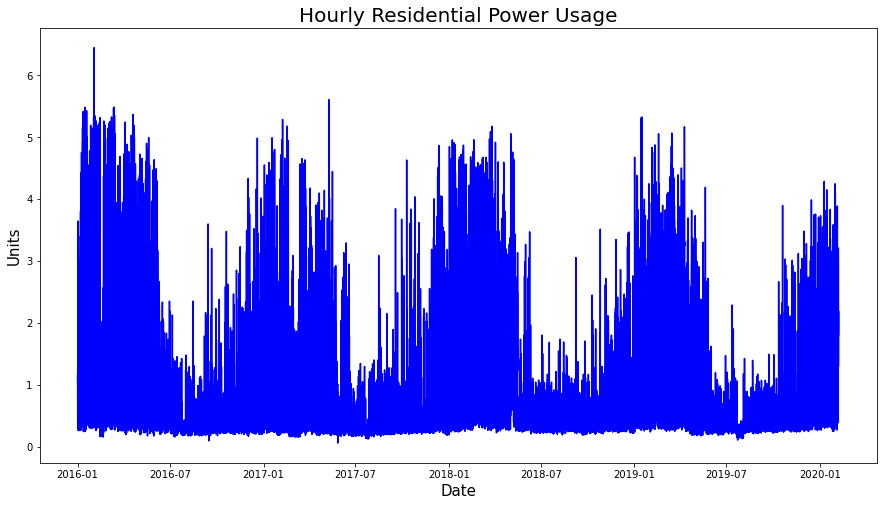

In [12]:
plt.plot(df,color='blue')
plt.title('Hourly Residential Power Usage',fontsize=20)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Units',fontsize=15)
plt.show()

In [13]:
plt.rcParams['figure.figsize'] = [15,8]

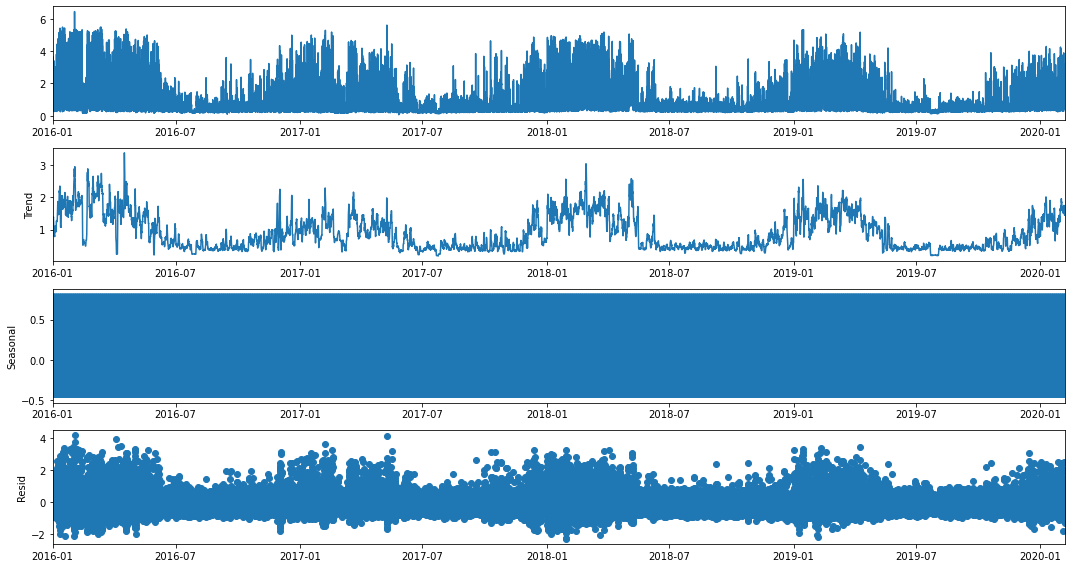

In [14]:
decomposition_model = seasonal_decompose(df,model='additive')
decomposition_model.plot();

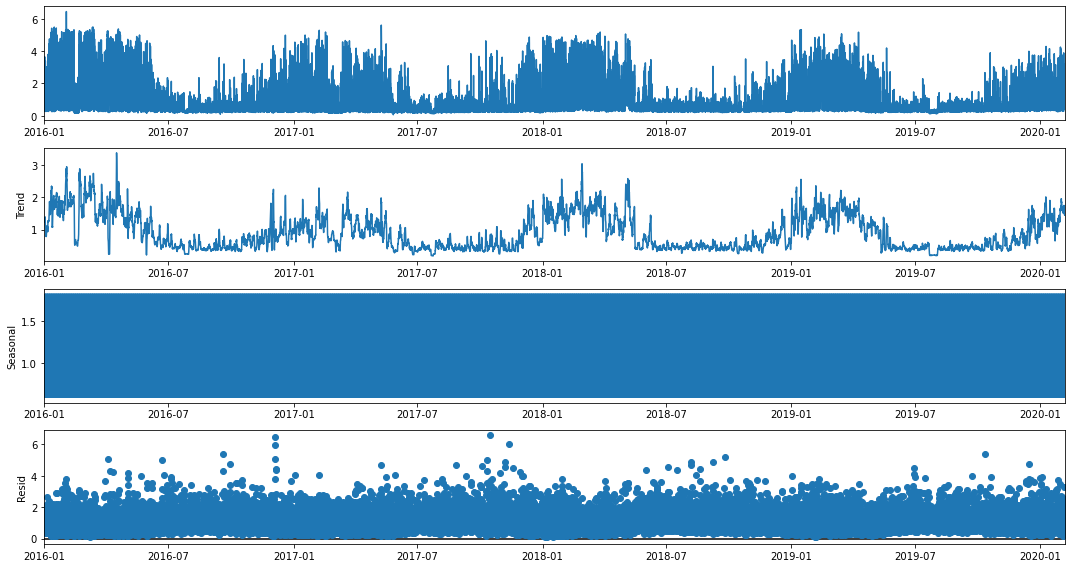

In [15]:
decomposition_model = seasonal_decompose(df,model='multiplicative')
decomposition_model.plot();

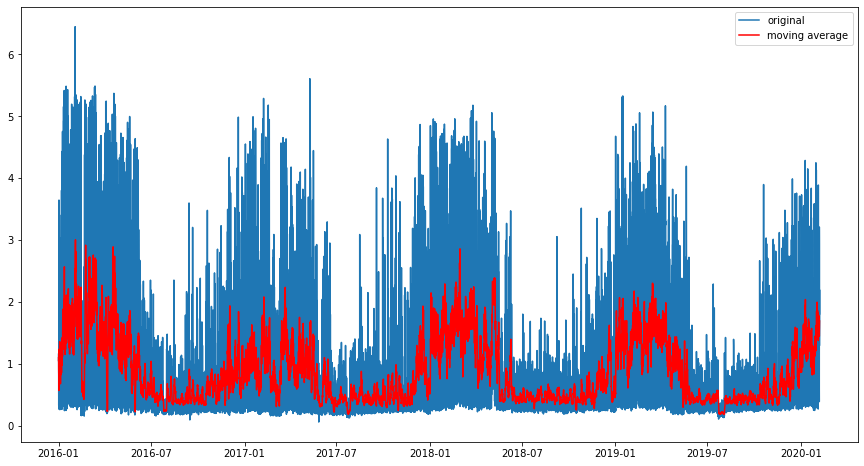

In [16]:
plt.plot(df,label='original')
plt.plot(df.rolling(40,min_periods=0).mean(),label='moving average',color='r')
plt.legend(loc='best')
plt.show()

In [17]:
# Model building - Exponential Smoothing Techniques

In [18]:
train = df.iloc[:32000,]
test = df.iloc[32000:,]

In [19]:
train.tail()

,value
time_stamp,
2019-08-26 03:00:00,0.308
2019-08-26 04:00:00,0.406
2019-08-26 05:00:00,0.468
2019-08-26 06:00:00,0.614
2019-08-26 07:00:00,0.297


In [20]:
test.head()

,value
time_stamp,
2019-08-26 08:00:00,0.250
2019-08-26 09:00:00,0.583
2019-08-26 10:00:00,0.312
2019-08-26 11:00:00,0.429
2019-08-26 12:00:00,0.410


In [21]:
len(train)

32000

In [22]:
len(test)

3952

##### Simple Exponential Smoothing

In [23]:
SES = SimpleExpSmoothing(train,initialization_method='estimated')
SES_model = SES.fit(optimized=True)
SES_model.summary()

Dep. Variable:,value,No. Observations:,32000
Model:,SimpleExpSmoothing,SSE,9544.463
Optimized:,True,AIC,-38708.791
Trend:,None,BIC,-38692.044
Seasonal:,None,AICC,-38708.790
Seasonal Periods:,None,Date:,"Mon, 04 Apr 2022"
Box-Cox:,False,Time:,16:40:58
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.8710171,alpha,True
initial_level,1.0620692,l.0,True


In [24]:
SES_predict = SES_model.forecast(len(test))

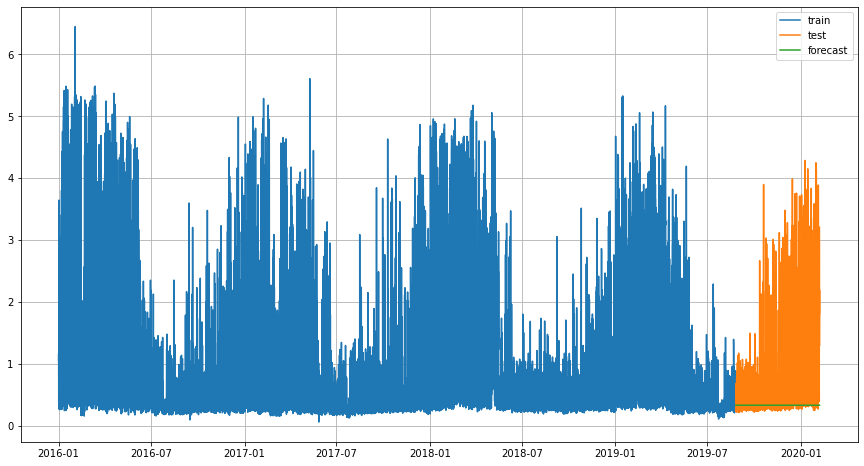

In [25]:
plt.plot(train,label='train')
plt.plot(test,label='test')
plt.plot(SES_predict,label='forecast')
plt.legend(loc='best')
plt.grid()
plt.show()

In [28]:
print("MAE:",MAE(test['value'],SES_predict))
print("MAPE:",MAPE(test['value'],SES_predict))

MAE: 0.4688925850601644
MAPE: 37.862823958084626


##### Double Exponential Smoothing

In [88]:
DES = Holt(train,exponential=False,initialization_method='estimated')
DES_model = DES.fit(smoothing_level=0.500122,
                   smoothing_trend=5.6013e-18)
DES_model.summary()

Dep. Variable:,value,No. Observations:,32000
Model:,Holt,SSE,10898.727
Optimized:,True,AIC,-34458.877
Trend:,Additive,BIC,-34425.383
Seasonal:,None,AICC,-34458.875
Seasonal Periods:,None,Date:,"Mon, 04 Apr 2022"
Box-Cox:,False,Time:,16:48:38
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.5001220,alpha,False
smoothing_trend,5.6013e-18,beta,False


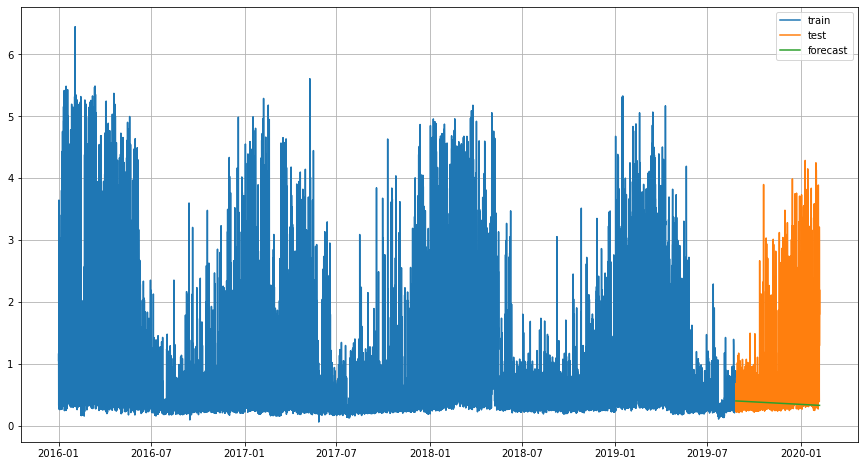

In [89]:
DES_predict = DES_model.forecast(len(test))

plt.plot(train,label='train')
plt.plot(test,label='test')
plt.plot(DES_predict,label='forecast')
plt.legend(loc='best')
plt.grid()
plt.show()

In [91]:
print("MAE:",MAE(test['value'],DES_predict))
print("MAPE:",MAPE(test['value'],DES_predict))

MAE: 0.4615520437116339
MAPE: 38.56982629371322


##### Triple Exponential Smoothing

In [92]:
TES = ExponentialSmoothing(train,trend='additive',seasonal='additive',initialization_method='estimated')
TES_model = TES.fit(smoothing_level=0.5181869,
    smoothing_trend=3.1332e-11,
    smoothing_seasonal=0.2074180)
TES_model.summary()

Dep. Variable:,value,No. Observations:,32000
Model:,ExponentialSmoothing,SSE,7971.835
Optimized:,True,AIC,-44418.279
Trend:,Additive,BIC,-44183.821
Seasonal:,Additive,AICC,-44418.221
Seasonal Periods:,24,Date:,"Mon, 04 Apr 2022"
Box-Cox:,False,Time:,17:04:30
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.5181869,alpha,False
smoothing_trend,3.1332e-11,beta,False


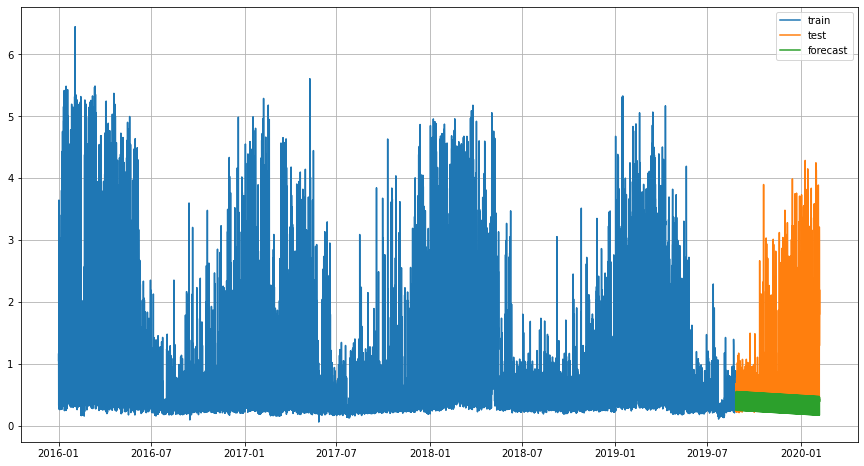

In [93]:
TES_predict = TES_model.forecast(len(test))

plt.plot(train,label='train')
plt.plot(test,label='test')
plt.plot(TES_predict,label='forecast')
plt.legend(loc='best')
plt.grid()
plt.show()

In [95]:
print("MAE:",MAE(test['value'],TES_predict))
print("MAPE:",MAPE(test['value'],TES_predict))

MAE: 0.4600439922150074
MAPE: 39.6316426279771


##### ACF and PACF plots

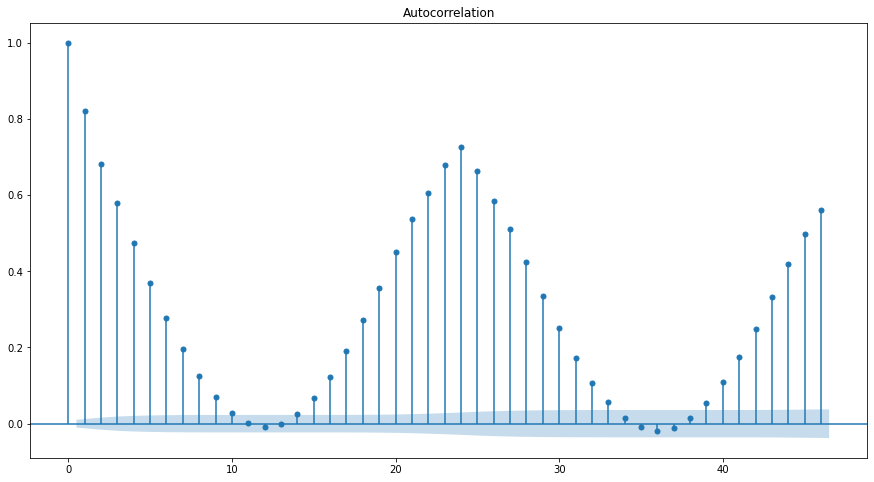

In [96]:
plot_acf(df)
plt.show()

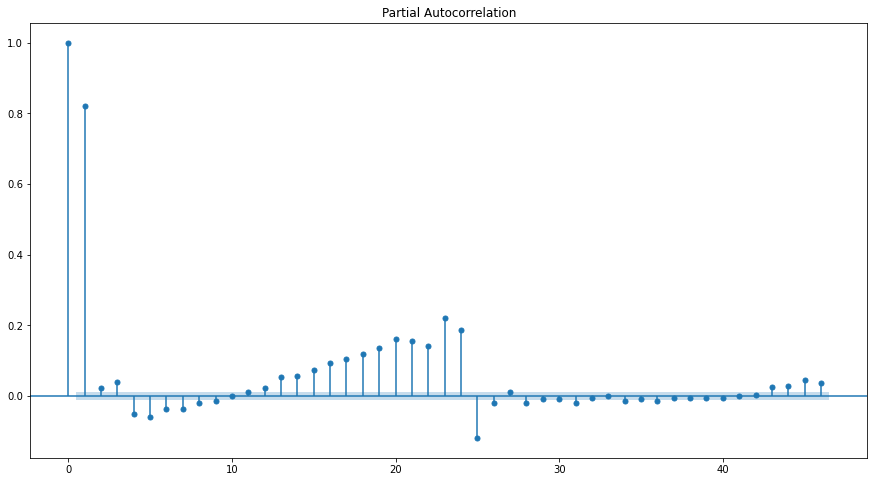

In [97]:
plot_pacf(df)
plt.show()

##### DickyFuller test

In [98]:
observations = df.values
df_results = adfuller(observations)
df_results

(-8.016613825427713,
 2.1304732797211598e-12,
 50,
 35901,
 {'1%': -3.4305321611549875,
  '5%': -2.8616205107926382,
  '10%': -2.5668128533534706},
 44969.70705930502)

In [99]:
##### stationary series -- proceed with ARMA & SARIMA model

##### ARMA Model

In [100]:
model_2=ARMA(train,(9,9))
model_fit_2=model_2.fit()
print(model_fit_2.summary())

                              ARMA Model Results                              
Dep. Variable:                  value   No. Observations:                32000
Model:                     ARMA(9, 9)   Log Likelihood              -21251.310
Method:                       css-mle   S.D. of innovations              0.470
Date:                Mon, 04 Apr 2022   AIC                          42542.620
Time:                        17:20:09   BIC                          42710.090
Sample:                    01-01-2016   HQIC                         42596.190
                         - 08-26-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.8940        nan        nan        nan         nan         nan
ar.L1.value     1.9245   4.83e-05   3.98e+04      0.000       1.924       1.925
ar.L2.value    -1.7203        nan        nan    

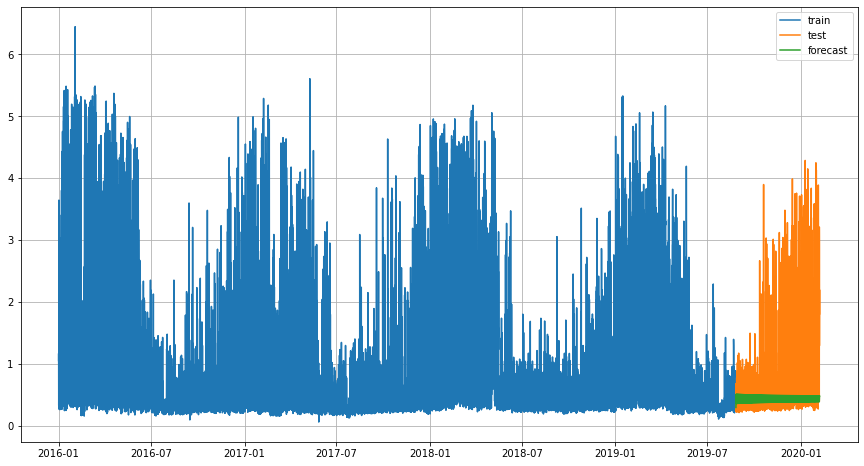

In [101]:
forecasted_values_arma_2 = pd.Series(model_fit_2.forecast(len(test))[0],index=test.index)

# visualizing the forecasted values:

plt.plot(train,label='train')
plt.plot(test,label='test')
plt.plot(forecasted_values_arma_2,label='forecast')
plt.grid()
plt.legend(loc='best')
plt.show()

In [102]:
print("MAE:",MAE(test['value'],forecasted_values_arma_2))
print("MAPE:",MAPE(test['value'],forecasted_values_arma_2))

MAE: 0.42919218941645126
MAPE: 38.480511707813186


In [115]:
model_2=ARMA(train,(1,1))
model_fit_2=model_2.fit()
print(model_fit_2.summary())

                              ARMA Model Results                              
Dep. Variable:                  value   No. Observations:                32000
Model:                     ARMA(1, 1)   Log Likelihood              -24792.063
Method:                       css-mle   S.D. of innovations              0.525
Date:                Mon, 04 Apr 2022   AIC                          49592.126
Time:                        17:32:06   BIC                          49625.620
Sample:                    01-01-2016   HQIC                         49602.840
                         - 08-26-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.9045      0.017     53.021      0.000       0.871       0.938
ar.L1.value     0.8315      0.004    217.921      0.000       0.824       0.839
ma.L1.value    -0.0204      0.007     -2.890    

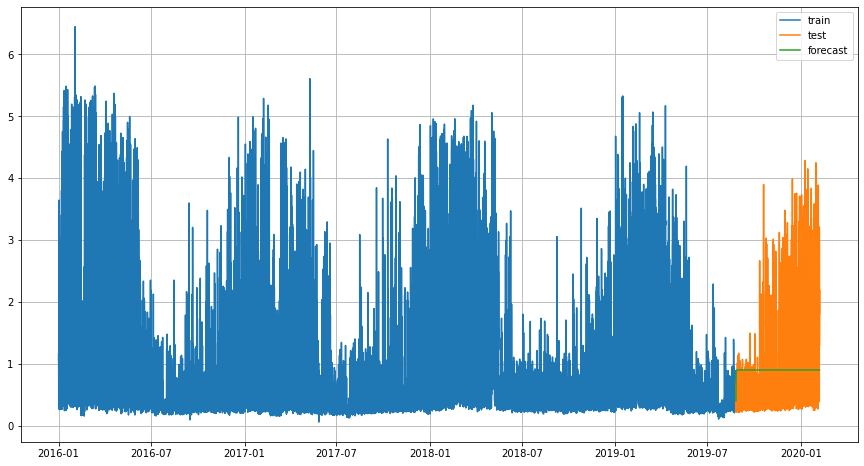

In [116]:
forecasted_values_arma_2 = pd.Series(model_fit_2.forecast(len(test))[0],index=test.index)

# visualizing the forecasted values:

plt.plot(train,label='train')
plt.plot(test,label='test')
plt.plot(forecasted_values_arma_2,label='forecast')
plt.grid()
plt.legend(loc='best')
plt.show()

In [117]:
print("MAE:",MAE(test['value'],forecasted_values_arma_2))
print("MAPE:",MAPE(test['value'],forecasted_values_arma_2))

MAE: 0.5628887105396306
MAPE: 105.05486641338007


In [112]:
model_2=ARMA(train,(2,3))
model_fit_2=model_2.fit()
print(model_fit_2.summary())

                              ARMA Model Results                              
Dep. Variable:                  value   No. Observations:                32000
Model:                     ARMA(2, 3)   Log Likelihood              -24607.561
Method:                       css-mle   S.D. of innovations              0.522
Date:                Mon, 04 Apr 2022   AIC                          49229.122
Time:                        17:29:04   BIC                          49287.736
Sample:                    01-01-2016   HQIC                         49247.871
                         - 08-26-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.9046      0.014     64.270      0.000       0.877       0.932
ar.L1.value     1.6284      0.016    100.457      0.000       1.597       1.660
ar.L2.value    -0.6932      0.014    -49.418    

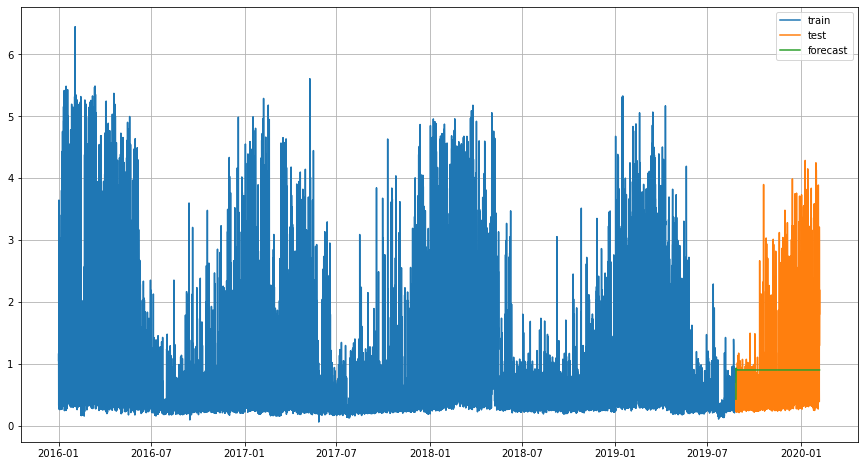

In [113]:
forecasted_values_arma_2 = pd.Series(model_fit_2.forecast(len(test))[0],index=test.index)

# visualizing the forecasted values:

plt.plot(train,label='train')
plt.plot(test,label='test')
plt.plot(forecasted_values_arma_2,label='forecast')
plt.grid()
plt.legend(loc='best')
plt.show()

In [114]:
print("MAE:",MAE(test['value'],forecasted_values_arma_2))
print("MAPE:",MAPE(test['value'],forecasted_values_arma_2))

MAE: 0.5632487306241639
MAPE: 105.15831337097137


In [118]:
model_2=ARMA(train,(5,5))
model_fit_2=model_2.fit()
print(model_fit_2.summary())

                              ARMA Model Results                              
Dep. Variable:                  value   No. Observations:                32000
Model:                     ARMA(5, 5)   Log Likelihood              -23109.785
Method:                       css-mle   S.D. of innovations              0.498
Date:                Mon, 04 Apr 2022   AIC                          46243.571
Time:                        17:43:52   BIC                          46344.053
Sample:                    01-01-2016   HQIC                         46275.713
                         - 08-26-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.9046      0.013     70.629      0.000       0.879       0.930
ar.L1.value     1.3275      0.001   1770.998      0.000       1.326       1.329
ar.L2.value     0.3125      0.002    182.815    

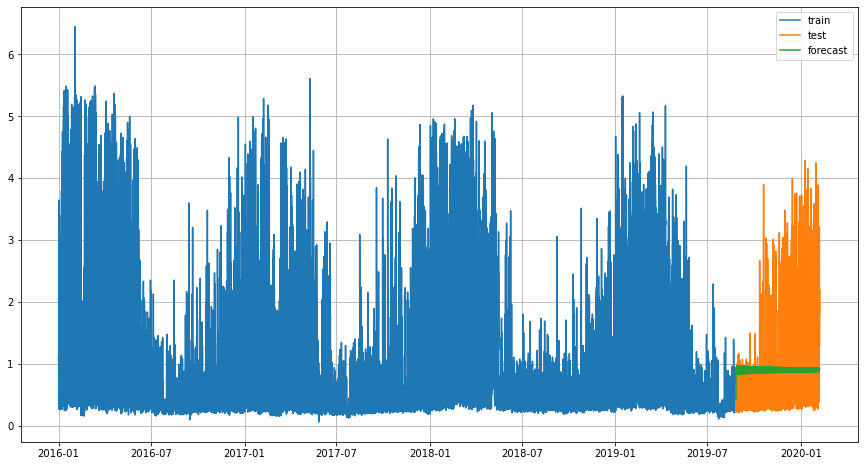

In [120]:
forecasted_values_arma_2 = pd.Series(model_fit_2.forecast(len(test))[0],index=test.index)

# visualizing the forecasted values:

plt.plot(train,label='train')
plt.plot(test,label='test')
plt.plot(forecasted_values_arma_2,label='forecast')
plt.grid()
plt.legend(loc='best')
plt.show()

In [121]:
print("MAE:",MAE(test['value'],forecasted_values_arma_2))
print("MAPE:",MAPE(test['value'],forecasted_values_arma_2))

MAE: 0.554782058581712
MAPE: 103.25586465346743


In [171]:
import itertools

##### SARIMA Model

In [122]:
model = SARIMAX(train,
                       order = (5,0,5),
                       seasonal_order = (5,0,5,10),
                       enforce_stationarity=False,
                       enforce_invertibility=False)
sarimax_results = model.fit()

In [187]:
print(sarimax_results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              value   No. Observations:                32000
Model:             SARIMAX(5, 0, 5)x(5, 0, 5, 10)   Log Likelihood              -22609.234
Date:                            Sun, 06 Feb 2022   AIC                          45260.468
Time:                                    18:50:51   BIC                          45436.274
Sample:                                01-01-2016   HQIC                         45316.709
                                     - 08-26-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4445      0.280      1.587      0.113      -0.105       0.994
ar.L2          0.0660      0.332   

In [124]:
forecast = sarimax_results.forecast(len(test))

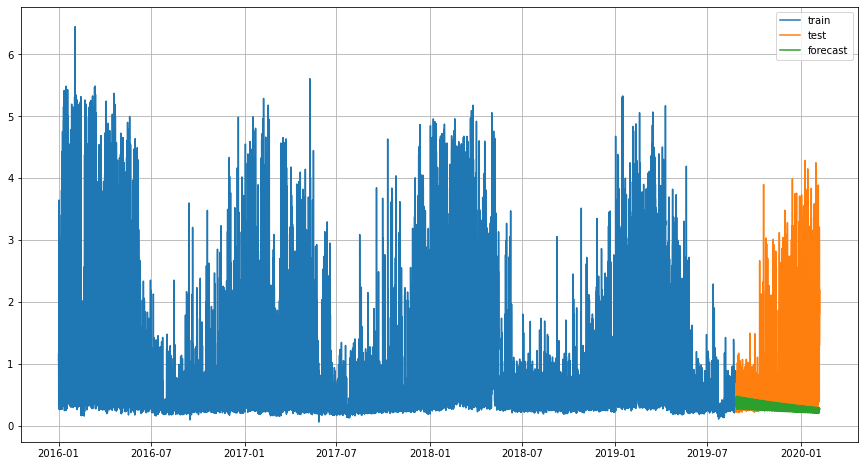

In [125]:
# visualizing the forecasted values:

plt.plot(train,label='train')
plt.plot(test,label='test')
plt.plot(forecast,label='forecast')
plt.grid()
plt.legend(loc='best')
plt.show()

In [126]:
print("MAE:",MAE(test['value'],forecast))
print("MAPE:",MAPE(test['value'],forecast))

MAE: 0.4909585346333718
MAPE: 41.660519729949414
